# Indeed job listing data - Exploratory Data Analysis (EDA) 

In [1]:
# Install necessary packages 
#!pip install missingno
#!pip install wordcloud

In [2]:
# Import necessary packages 
import numpy as np
import pandas as pd 
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from collections import defaultdict

%matplotlib inline

In [3]:
import utils.my_functions as mf
# Activate autoreload to enable changes in the imported functions without having to reboot kernel
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Constants and configurations
DATA_PATH = 'output/indeed_jobs_'

# Keyword dictionaries 
import utils.dictionaries as dicts

## Load the data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [5]:
# Import csv files with scraped data for resp. country 
# Sweden 
df_SWE = pd.read_csv(f"{DATA_PATH}{'Sweden'}.csv")
# France 
df_FRA = pd.read_csv(f"{DATA_PATH}{'France'}.csv")
# Italy
df_ITA =pd.read_csv(f"{DATA_PATH}{'Italy'}.csv")

In [6]:
# USA 
df_USA = mf.merge_US_cities(['NY', 'LA', 'CHI'], DATA_PATH)

Loaded data for NY
Column order for consistency: ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial inspection of the data

In [7]:
df_SWE.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [8]:
df_FRA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [9]:
df_ITA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [10]:
df_USA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [11]:
# Check dimensions of dfs 
print(f'SWE \t   columns: {df_SWE.shape[1]} \t  rows: {df_SWE.shape[0]}')
print(f'FRA \t   columns: {df_FRA.shape[1]} \t  rows: {df_FRA.shape[0]}')
print(f'ITA \t   columns: {df_ITA.shape[1]} \t  rows: {df_ITA.shape[0]}')
print(f'USA \t   columns: {df_USA.shape[1]} \t  rows: {df_USA.shape[0]}')

SWE 	   columns: 10 	  rows: 320
FRA 	   columns: 10 	  rows: 2200
ITA 	   columns: 10 	  rows: 769
USA 	   columns: 10 	  rows: 1317


In [12]:
# Check data types
df_SWE.info() 
# Most columns are of type 'Dtype object'
# Convert columns with strings only to string data type to optimize performance
# Mixed columns with both numbers and strings: company_location, salary, job_link (url) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [13]:
# Convert objects to strings 
df_SWE = df_SWE.astype(dicts.dtype_dict)

# Output new data types
print(df_SWE.dtypes) # Is string[python] not dtype string?

page                         int64
country             string[python]
job_link                    object
search_keyword      string[python]
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [14]:
# Do the same for the other datasets 
df_FRA = df_FRA.astype(dicts.dtype_dict)
df_ITA = df_ITA.astype(dicts.dtype_dict)
df_USA = df_USA.astype(dicts.dtype_dict)

### Conclusions
- The following columns needs to be cleaned: search_keyword, job_title, job_description, company_location.   
- The salary column should be split into two columns (separate numeric vs string content).    

## Data reduction and data cleaning
Handle missing and duplicate data entries. Remove unnecessary columns (if any). 
Clean and preprocess the data to handle anomalies and outliers. 

### Missing values

In [15]:
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
df_SWE.replace('Not available', np.NaN, inplace=True)
df_FRA.replace('Not available', np.NaN, inplace=True) 
df_ITA.replace('Not available', np.NaN, inplace=True)
df_USA.replace('Not available', np.NaN, inplace=True)

df_FRA.isnull().sum() # Missing salary and job description entries 
df_SWE.isnull().sum() # Missing salary entries 
df_ITA.isnull().sum() # Missing salary entries 
df_USA.isnull().sum() # Missing salary entries 

# Calculate percentage of missing values
df_FRA.isnull().mean() * 100

# Salary entries will be examined later when columns are split 
# For now we do not drop these rows (we are not primarily interested in salaries)

page                 0.000000
country              0.000000
job_link             0.000000
search_keyword       0.000000
search_location      0.000000
job_title            0.000000
company_name         0.000000
company_location     0.000000
salary              17.181818
job_description      2.318182
dtype: float64

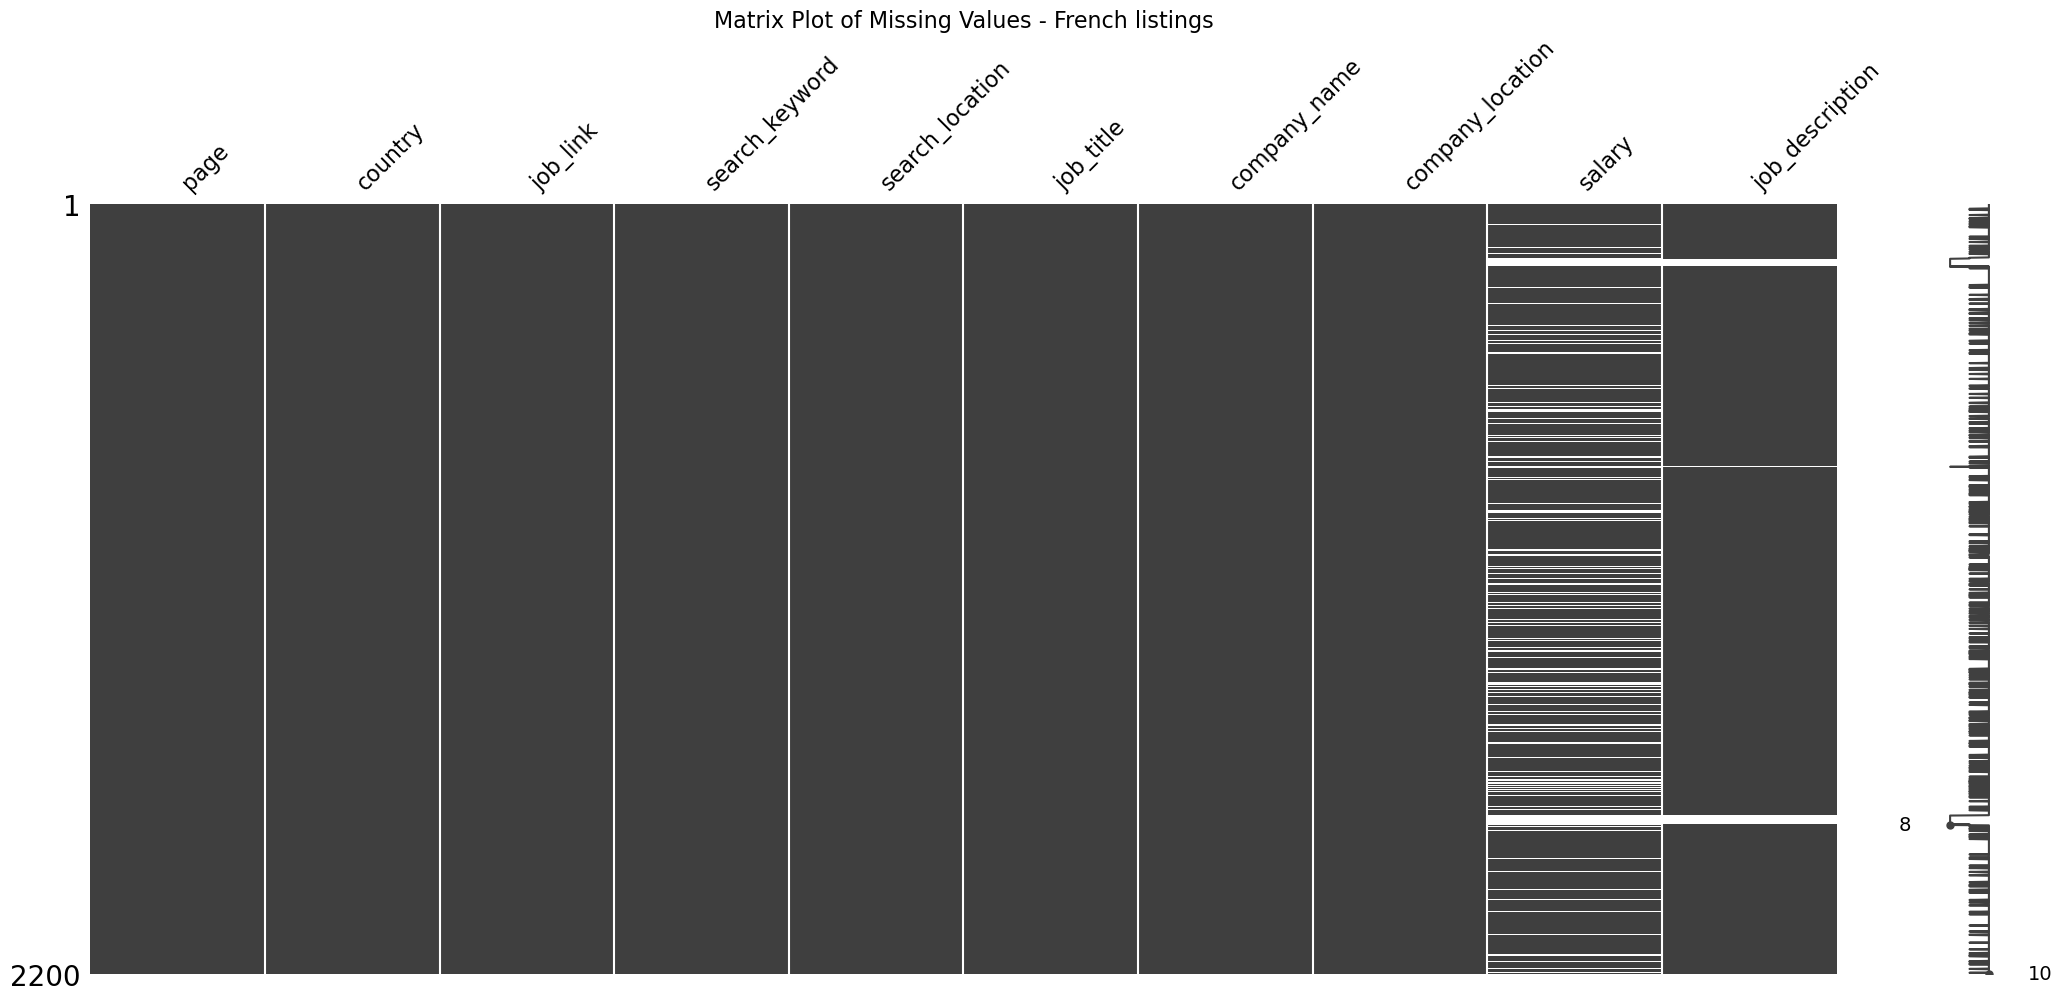

In [16]:
# Visualize missing data patterns using missingno
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  # Add a title to the plot
plt.show()

In [17]:
# Look into the missing descriptions for French job listings (seems that requests were blocked here?)
print(df_FRA.isnull().sum())
#df_FRA[df_FRA['job_description'].isnull()]

# Manual imports of missing job descriptions from URLs 
df_FRA_missing = pd.read_csv('df_FRA_missing_data.csv')

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [18]:
# Merge the DataFrames based on the 'job_link' column
merged_df = pd.merge(df_FRA, df_FRA_missing, on=['job_link'])
merged_df = pd.merge(df_FRA, df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')
# Save the job description as only one column (based on when it is not NaN)
merged_df['job_description'] = merged_df['job_description'].combine_first(merged_df['job_description_new'])
merged_df.drop('job_description_new', axis=1, inplace=True)
# Verify that there are no missing values in job_description now
merged_df.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [19]:
merged_df.isnull().sum()
df_FRA = merged_df
print(df_FRA.isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


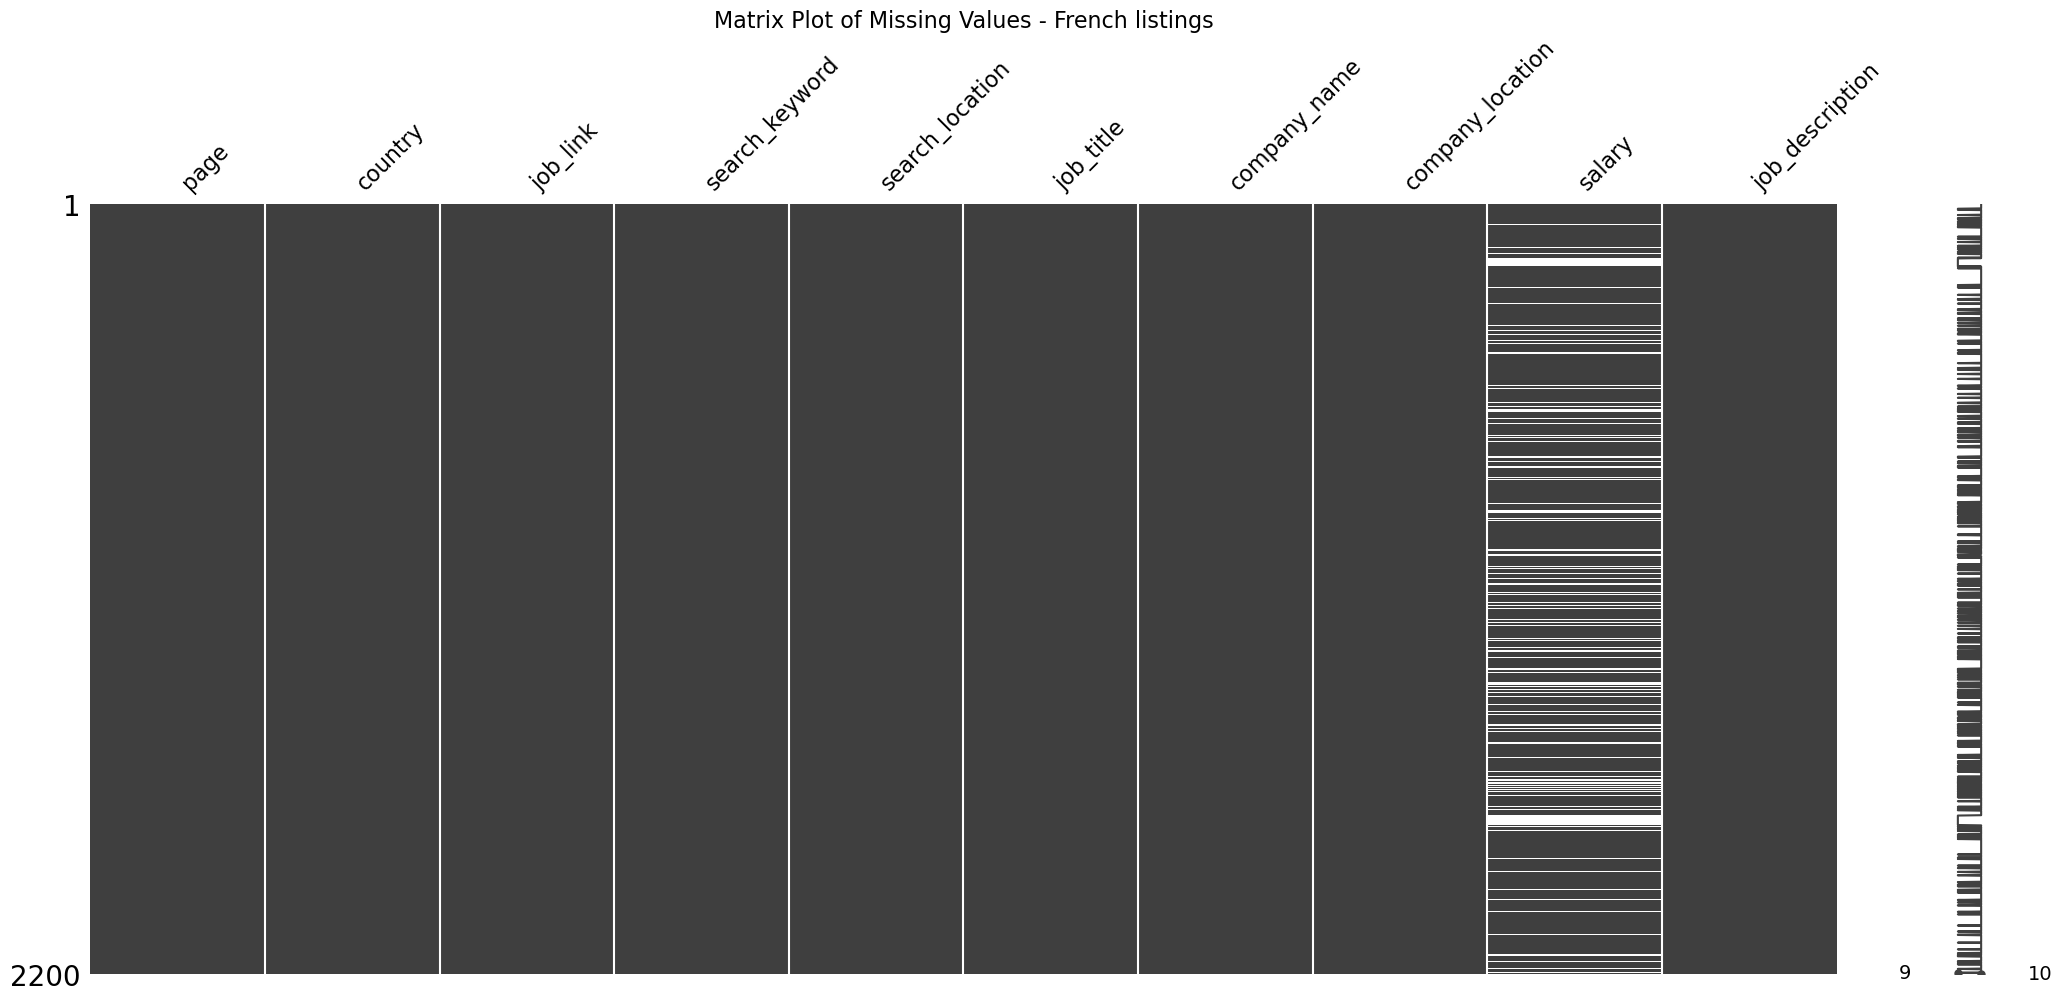

In [20]:
# Now the job_description should not have missing values anymore
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [21]:
# Make sure all data types are the same after adding info from CSV
df_FRA = df_FRA.astype(dicts.dtype_dict)
print(df_FRA.dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword      string[python]
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [22]:
# There are still many missing values for salary, but this is since that information was not always provided in the job listings
#df_FRA[df_FRA['salary'].isnull()]
df_FRA.isnull().sum()

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64

### Check for duplicates

In [23]:
# Check for potential duplicates 
mf.check_duplicates(df_FRA)
mf.check_duplicates(df_SWE)
mf.check_duplicates(df_ITA)
mf.check_duplicates(df_USA)

The DataFrame has 2200 rows.
page                  47
country                1
job_link            2200
search_keyword         4
search_location        3
job_title           1213
company_name         718
company_location     256
salary               164
job_description     1355
dtype: int64
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []
The DataFrame has 320 rows.
page                  7
country               1
job_link            320
search_keyword        4
search_location       3
job_title           198
company_name        198
company_location     88
salary               10
job_description     263
dtype: int64
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []
The DataFrame has 769 rows.
page                 20
country               1
job_link            769
sea

No rows are completely identical, but perhaps there are <i>job descriptions</i> that are identical? 

In [24]:
# Identify duplicates (same job title, location, and job description, and keep only the latest job listing(
df_SWE = mf.remove_duplicates_jobdesc(df_SWE) 
df_FRA = mf.remove_duplicates_jobdesc(df_FRA) 
df_ITA = mf.remove_duplicates_jobdesc(df_ITA)
df_USA = mf.remove_duplicates_jobdesc(df_USA) 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 3200 Size after removing duplicates: 2630
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 22000 Size after removing duplicates: 13650
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 7690 Size after removing duplicates: 5690
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 13170 Size after removing duplicates: 8350


There are numerous examples of when job descriptions are completely identical. These are likely reposts (the same job appearing multiple times, just with different unique links!). 
<b>Remove these entries if the job titles are the same and the locations are the same.</b> 

## Descriptive statistics

In [25]:
# Describe (numerical) columns  
df_SWE.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,263.000000,263,263,263,263,263,263,263,113,263
unique,NaN,1,263,4,3,198,198,88,10,263
top,NaN,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Scientist,Stockholm,Systemutvecklare,Cubane Solutions AB,Stockholm,Heltid,Company Description \n Statistics show that w...
freq,NaN,263,1,131,186,19,7,69,58,1
mean,2.593156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.789993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Describe categorical columns  
mf.desc_categorical(df_SWE) 

Value counts for column: country
country
Sweden    263
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Scientist     131
Product+Analyst     77
BI+Analyst          41
Data+Analyst        14
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Stockholm    186
Göteborg      54
Malmö         23
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Systemutvecklare                                 19
Data Analyst                                     13
Data Scientist                                   12
Business Analyst                                  8
Senior Data Scientist                             5
                                                 ..
Senior Business Intelligence Analyst              1
Senior Logistics Analyst                          1
PowerBI utvecklare                                1
BI-konsult / Data Analyst / Data Scientist        1
Production Analytics Lead [Game Intelligence

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Systemutvecklare, Data Analyst, Data Scientist.
- __Most frequent company__: Cubane Solutions AB. 
- __Company location__: Stockholm primarily. 
- __Salary ranges__: Few numerical values are provided.

In [27]:
df_FRA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,1365.000000,1365,1365,1365,1365,1365,1365,1365,1107,1365
unique,NaN,1,1365,4,3,1213,717,256,164,1355
top,NaN,France,https://www.indeed.fr/rc/clk?jk=307bf16bdd8ce5...,Product+Analyst,Paris (75),Data Analyst H/F,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...
freq,NaN,1365,1,502,1198,13,37,380,300,4
mean,16.523810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,12.436244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
mf.desc_categorical(df_FRA) 

Value counts for column: country
country
France    1365
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Product+Analyst    502
BI+Analyst         375
Data+Analyst       288
Data+Scientist     200
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Paris (75)        1198
Lyon (69)          133
Marseille (13)      34
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst H/F                                                  13
Data Analyst                                                       8
Data Analyst Intern                                                8
Data Scientist                                                     8
Data Scientist H/F                                                 8
                                                                  ..
VIE Procurement Distribution & Perf.                               1
SENIOR DATA ENGINEER AWS (F/H)                                

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst (many similar names for this title, e.g. Data Analyst H/F and Data Analyst Intern). 
- __Most frequently mentioned company__: AXA.
- __Company location__: Most in Paris. Includes some information about télétravail (especially common in Paris).  
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [29]:
df_ITA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,569.000000,569,569,569,569,569,569,569,18,569
unique,NaN,1,569,4,3,469,309,96,14,554
top,NaN,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Milano, Lombardia",Data Scientist,BIP - Business Integration Partners,"Milano, Lombardia",1.000 € al mese,"NTT DATA, Trusted Global Innovator, è tra i pr..."
freq,NaN,569,1,260,390,31,30,149,3,3
mean,5.495606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.095952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
mf.desc_categorical(df_ITA) 

Value counts for column: country
country
Italy    569
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       260
Data+Scientist     150
BI+Analyst          87
Product+Analyst     72
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Milano, Lombardia    390
Roma, Lazio          159
Napoli, Campania      20
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Scientist                      31
Data Analyst                        12
Business Analyst                     8
Senior Data Analyst                  5
Junior Data Analyst                  3
                                    ..
Demand Planner - Confectionery       1
Junior Business Analyst AUTOHERO     1
BI Engineer                          1
DATA SCIENTIST MIDDLE                1
CRM Analyst                          1
Name: count, Length: 469, dtype: Int64

Value counts for column: company_name
company_name
BIP - Business Integr

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Analyst, Data Scientist, Business Analyst. 
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Very few numerical entries provided. 

In [31]:
df_USA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,835.000000,835,835,835,835,835,835,835,789,835
unique,NaN,1,835,4,3,739,470,185,524,823
top,NaN,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Scientist,"New+York, NY",Data Analyst,Citi,"New York, NY",Full-time,A career in Products and Technology is an oppo...
freq,NaN,835,1,264,487,12,27,179,149,2
mean,6.234731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.419001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
mf.desc_categorical(df_USA) 

Value counts for column: country
country
USA    835
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Scientist     264
BI+Analyst         263
Data+Analyst       237
Product+Analyst     71
Name: count, dtype: Int64

Value counts for column: search_location
search_location
New+York, NY       487
Chicago, IL        264
Los+Angeles, CA     84
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst                                 12
Business Analyst                             11
Senior Data Scientist                         8
Senior Machine Learning Engineer              8
Senior Business Analyst                       5
                                             ..
Capital Market Production Support Analyst     1
Marketing Campaign Data Analyst (Hybrid)      1
Product Strategy Associate                    1
Senior FPA Analyst                            1
Sr. Director of Data, Analytics and AI        1
Name: count, Length: 

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, BI analyst, (Senior) Data Scientist. Interesting that Machine Learning Engineer shows up. Might need to cluster similar terms to get full picture (e.g. remove Senior etc.). 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

## Feature engineering 

### Retrieve numeric values for salary

In [33]:
# Dictionary of data frames 
dfs = {'SWE': df_SWE, 'FRA': df_FRA, 'ITA': df_ITA, 'USA': df_USA}

# Loop through the dictionary and apply the function to clean dfs and add currency and salaries
dfs = {key: mf.clean_and_add_currency_and_salaries(df, dicts.currency_mapping[key]) for key, df in dfs.items()}

In [34]:

'''
# Unpack the cleaned DataFrames
df_SWE, df_FRA, df_ITA, df_USA = dfs.values()

# Inspect output 
print(df_ITA.isnull().sum())
# Check salary ranges 
df_ITA.describe()
# Filter out data when column 'salary_num' is not NaN
df_filtered = df_ITA.dropna(subset=['salary_num'])
df_filtered
'''

"\n# Unpack the cleaned DataFrames\ndf_SWE, df_FRA, df_ITA, df_USA = dfs.values()\n\n# Inspect output \nprint(df_ITA.isnull().sum())\n# Check salary ranges \ndf_ITA.describe()\n# Filter out data when column 'salary_num' is not NaN\ndf_filtered = df_ITA.dropna(subset=['salary_num'])\ndf_filtered\n"

In [35]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)

# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))
df_combined.describe()

,page,salary_num_low,salary_num_high,min_salary_month,max_salary_month,date
count,3032.000000,8.200000e+02,8.200000e+02,8.200000e+02,8.200000e+02,3032
mean,10.412269,3.211484e+05,4.760533e+05,3.756959e+04,5.321188e+04,2024-09-19 15:18:31.345646592
min,1.000000,6.000000e+00,6.000000e+00,6.000000e+00,3.416667e+00,2024-09-19 00:00:00
25%,3.000000,5.000000e+04,6.500000e+04,4.900000e+03,6.412000e+03,2024-09-19 00:00:00
50%,6.000000,9.000000e+04,1.294000e+05,7.916667e+03,1.126000e+04,2024-09-20 00:00:00
75%,15.000000,1.308000e+05,2.000000e+05,1.165417e+04,1.698125e+04,2024-09-20 00:00:00
max,47.000000,1.250912e+07,2.842800e+07,1.096960e+06,2.369000e+06,2024-09-20 00:00:00
std,10.563513,1.427072e+06,2.191826e+06,1.449375e+05,2.096597e+05,NaN


In [36]:
# Maybe good to assign a job id to a column, instead of checking for unique URLs 
df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))

In [37]:
df_combined.head(5)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,salary_num,salary_num_low,salary_num_high,time_period,currency,min_salary_month,max_salary_month,date
0,1,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
1,2,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,Fraud & Data Analyst to The Fraud Strategy & A...,Entercard Group AB,111 39 Stockholm,nan,About Entercard Entercard is one of Scandin...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
2,3,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,Data Analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,nan,About Star Stable Entertainment Once upon a ...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
3,4,1,Sweden,https://se.indeed.com/rc/clk?jk=7fa39868401ee6...,Data Analyst,Stockholm,Data Analyst,Baby Journey AB,114 51 Stockholm,nan,Baby Journey lanserades hösten 2020 och är en ...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
4,5,2,Sweden,https://se.indeed.com/rc/clk?jk=e8928767cb355b...,Data Analyst,Stockholm,OiT-237 Data Classification and Labeling Analyst,WSP Sverige,111 20 Stockholm,nan,WSP is a global consulting firm assisting pub...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19


### Detect keywords 

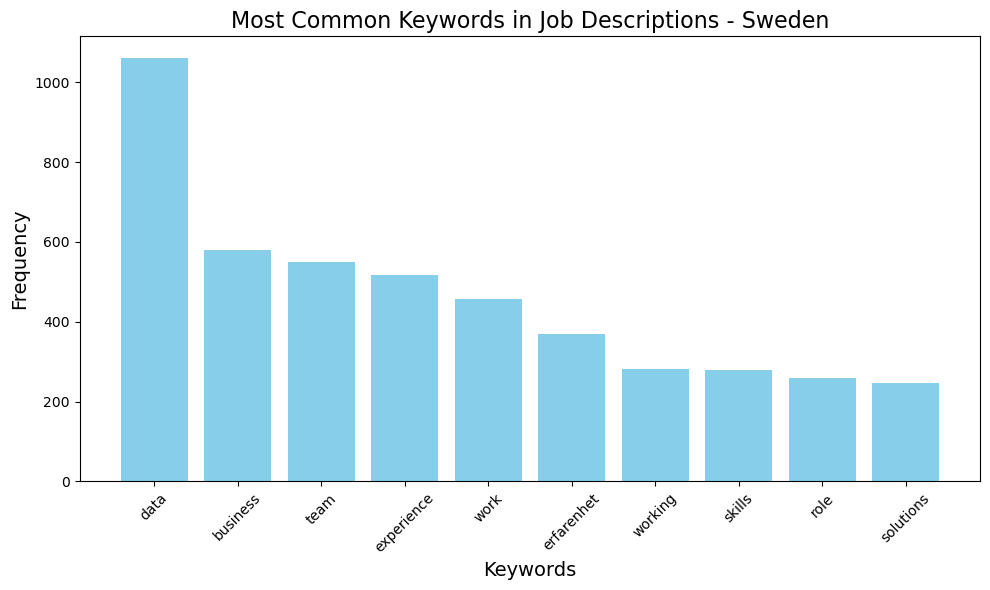

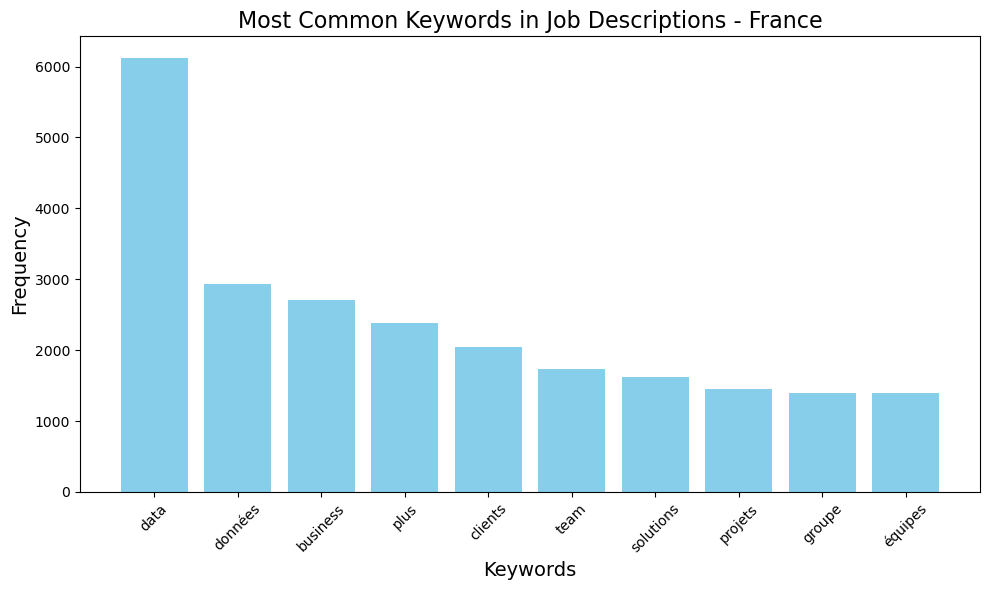

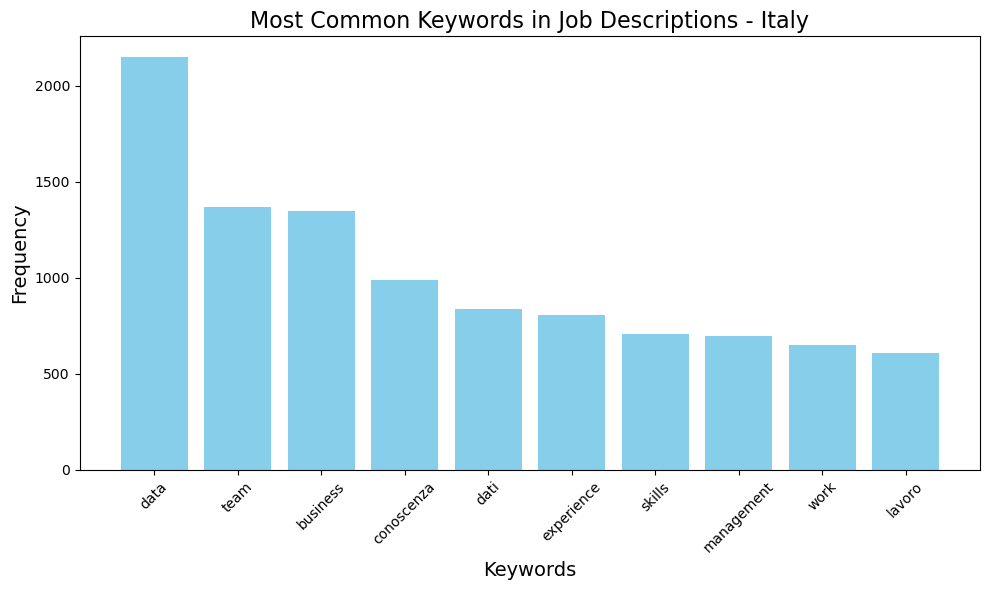

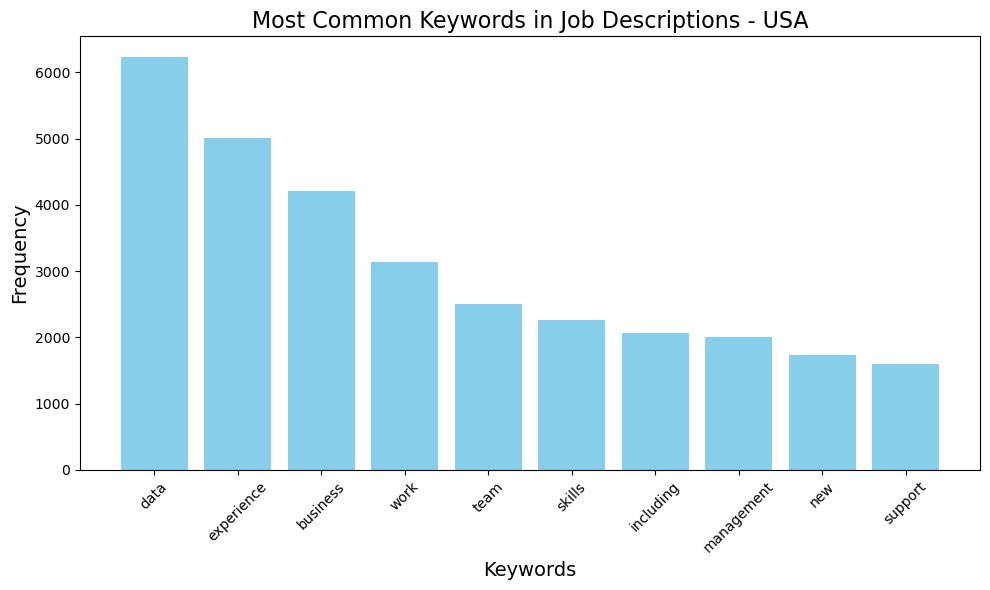

In [38]:
# Extract keywords 
common_keywords_SWE = mf.extract_keywords(df_combined, 'Sweden', 'swedish')
common_keywords_FRA = mf.extract_keywords(df_combined, 'France', 'french')
common_keywords_ITA = mf.extract_keywords(df_combined, 'Italy', 'italian')
common_keywords_USA = mf.extract_keywords(df_combined, 'USA', 'english')

# Plot common keywords 
mf.plot_common_keywords(common_keywords_SWE[0], 'Sweden')
mf.plot_common_keywords(common_keywords_FRA[0], 'France')
mf.plot_common_keywords(common_keywords_ITA[0], 'Italy')
mf.plot_common_keywords(common_keywords_USA[0], 'USA')

In [52]:
# Calculate software/programming keyword counts for each country 
keyword_counts_SWE = mf.count_keywords(df_combined, 'Sweden', dicts.software_keywords)
keyword_counts_FRA = mf.count_keywords(df_combined, 'France', dicts.software_keywords)
keyword_counts_ITA = mf.count_keywords(df_combined, 'Italy', dicts.software_keywords)
keyword_counts_USA = mf.count_keywords(df_combined, 'USA', dicts.software_keywords)

# Combine all dfs into one
keyword_counts_combined = pd.concat([keyword_counts_SWE, keyword_counts_FRA, keyword_counts_ITA, keyword_counts_USA], ignore_index=True)
keyword_counts_combined.sort_values(by=['Count'], ascending=[False])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Category,Keyword,Search Keyword,Country,Count
333,Development Tools,git,Product Analyst,France,524
230,Data Analysis and Manipulation,excel,Product Analyst,France,461
275,Data Visualization and Business Intelligence (...,power bi,BI Analyst,France,357
331,Development Tools,git,Data Analyst,France,349
724,Data Analysis and Manipulation,excel,BI Analyst,USA,342
...,...,...,...,...,...
85,Development Tools,atom,Data Scientist,Sweden,1
523,Data Visualization and Business Intelligence (...,looker studio,Data Analyst,Italy,1
755,Data Visualization and Business Intelligence (...,looker studio,BI Analyst,USA,1
519,Data Visualization and Business Intelligence (...,looker,BI Analyst,Italy,1


In [99]:
# Extract interview information
interview_info_df, interview_flags_df = mf.extract_interview_details(df_combined)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
# Sum only Boolean columns in interview_flags_df to count occurrences of each stage
stage_counts = interview_flags_df.select_dtypes(include='bool').sum()
stage_counts

phone_screening          6
technical_screening      7
case_study              16
coding_assessment        6
behavioral_interview     4
on_site_interview        2
presentation             0
dtype: int64

In [101]:
filtered_df = interview_info_df[interview_info_df['case_study_text'].notna()]
filtered_df

,job_id,job_title,job_link,phone_screening_text,technical_screening_text,case_study_text,coding_assessment_text,behavioral_interview_text,on_site_interview_text,presentation_text
284,285,Transversal Business Analyst - Internship - Pa...,https://www.indeed.fr/rc/clk?jk=6005a985b0c4c2...,None,None,ition team. Excel case study. Final interv...,None,None,None,None
775,776,Strategy & Operations Intern,https://www.indeed.fr/rc/clk?jk=b734e01506d4df...,ion form on Lever Screening call with curren...,None,Mission-specific case study with our Head of S...,None,None,None,None
787,788,Data Analyst - Product Strategy (M/F/X),https://www.indeed.fr/rc/clk?jk=fe2845dfc269a5...,None,None,you to carry out a case study and meet your li...,None,None,None,None
822,823,Data Analyst (Internship),https://www.indeed.fr/rc/clk?jk=97e4f13fbdafbf...,None,None,epare and present a case study to both Joshua ...,None,None,None,None
873,874,Supply and Forecast Analyst - Fixed-term contr...,https://www.indeed.fr/rc/clk?jk=810703d4ec1e96...,None,None,about Bene Bono. Case study here! Do your be...,None,None,None,None
977,978,Senior Data Analyst,https://www.indeed.fr/rc/clk?jk=55d11783edfd15...,None,None,ruiter (30 min) A case study interview to di...,None,None,None,None
1146,1147,(Senior) Data Engineer - France (F/M/D),https://www.indeed.fr/rc/clk?jk=565cd6d1905fb5...,None,None,he Hiring Manager Business Case Final Inte...,None,None,None,None
1149,1150,Senior Data Scientist Freelance,https://www.indeed.fr/rc/clk?jk=145b5d3a462269...,None,None,ur future manager Case study An interview ...,None,None,None,None
1157,1158,Senior Data Engineer,https://www.indeed.fr/rc/clk?jk=4668efee5b7803...,None,None,ls (75 minutes) A case study interview to co...,None,None,None,None
1180,1181,Lead Data Scientist,https://www.indeed.fr/rc/clk?jk=18430b9c44f738...,None,None,ur future manager Case study An interview ...,None,None,None,None


These results should be taken with a pinch of salt since they are only in English. 

In [43]:
# Specify the job IDs you want to compare
job_id_1 = 2581
job_id_2 = 2714

# Filter the rows for these specific job IDs and select the column
description_1 = df_combined.loc[df_combined['job_id'] == job_id_1, 'job_description'].values[0]
description_2 = df_combined.loc[df_combined['job_id'] == job_id_2, 'job_description'].values[0]

# Compare the two values
if description_1 == description_2:
    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are the same.")
else:
    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are different.")


The job descriptions for job IDs 2581 and 2714 are different.


In [44]:
description_1

'Job Family:  Strategy & Transformation Consulting    Travel Required:  Up to 25%    Clearance Required:  Ability to Obtain Public Trust   What You Will Do:   Guidehouse is a leading management consulting firm serving the public and commercial markets. We guide our clients towards new futures that build trust in society and your professional skills along the journey.    We are looking for a Managing Consultant to join our Life Sciences team, which supports pharmaceutical and biotech companies with commercial insights, strategy, and implementation. This role will collaborate with our Life Science advisory teams, data teams, and our firmwide Advanced Analytics and Intelligent Automation team to shape the growth of our Life Science data services business.   Candidates should be market-facing self-starters who take ownership of their work, are enthusiastic, and have a collaborative mindset to support our efforts to sell and provide consulting solutions. You will coordinate activities acros

Information about the interview process seems to mostly be missing/left out from the job listnings. However, the most common category appears to be stages such as case studies, followed by phone screening, coding assessments, and presentations?

## Univariate analysis 


In [45]:
# histograms for salaries 
# to do 

## Bivariate analysis 

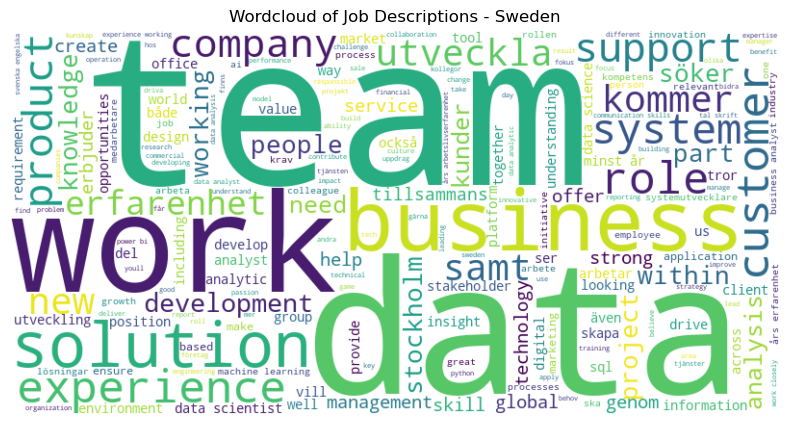

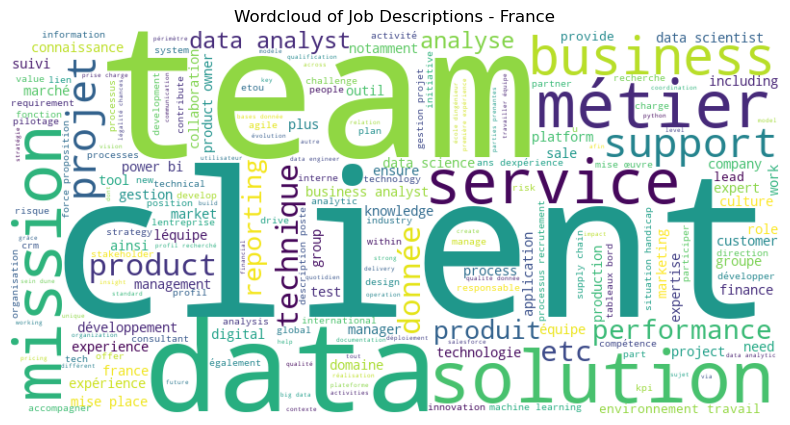

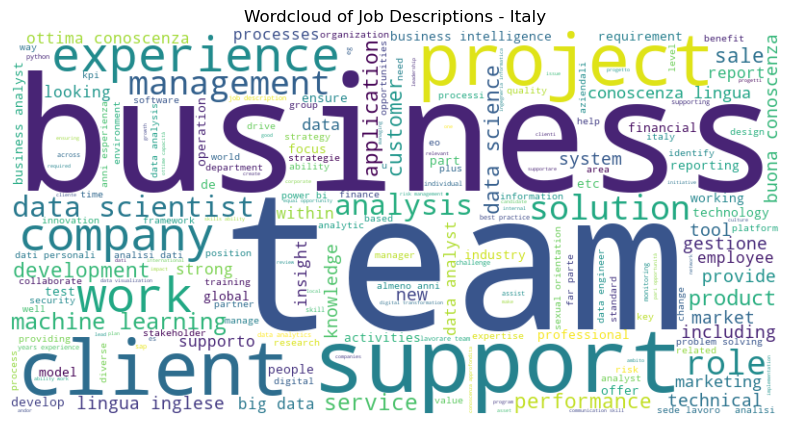

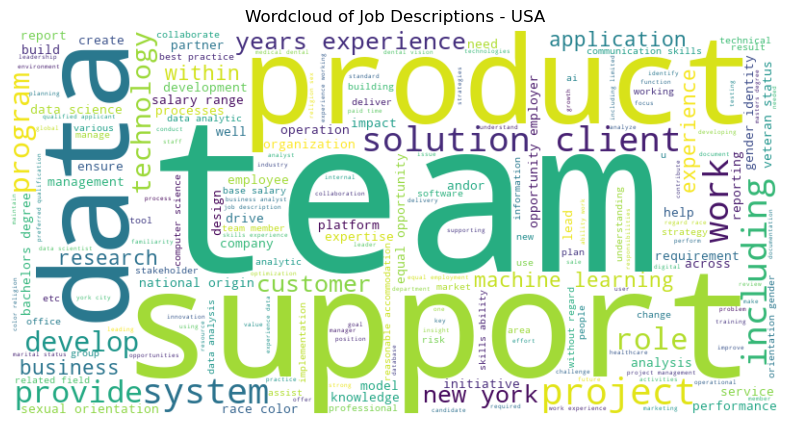

In [46]:
# Word cloud visualizations per country
def plt_wordtree(data, country):
    #df = data['job_description']
    #country = 'France'
    # Combine all the text into a single string 
    text = ' '.join(data)
    # Create a wordcloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Display the wordcloud 
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud of Job Descriptions - {country}')
    plt.axis('off')
    plt.show()

plt_wordtree(common_keywords_SWE[1], 'Sweden')
plt_wordtree(common_keywords_FRA[1], 'France')
plt_wordtree(common_keywords_ITA[1], 'Italy')
plt_wordtree(common_keywords_USA[1], 'USA')

In [47]:
# Add also word cloud visualizations per job title? 

In [48]:
# Box plots help visualize the distribution of salary ranges across different categories (e.g., job titles, countries).
# Look at outliers

# Number of job listings per job title and country 

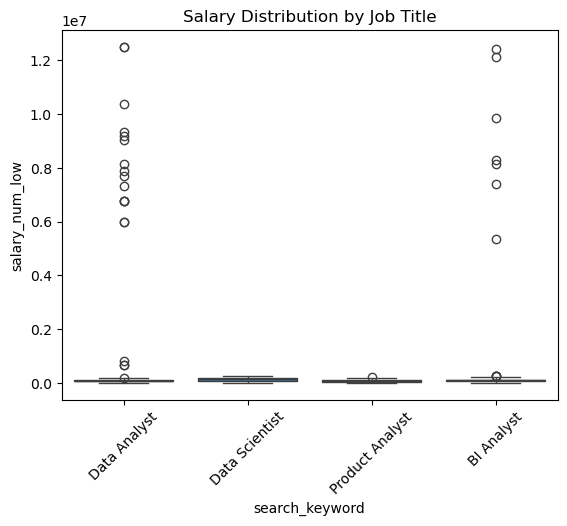

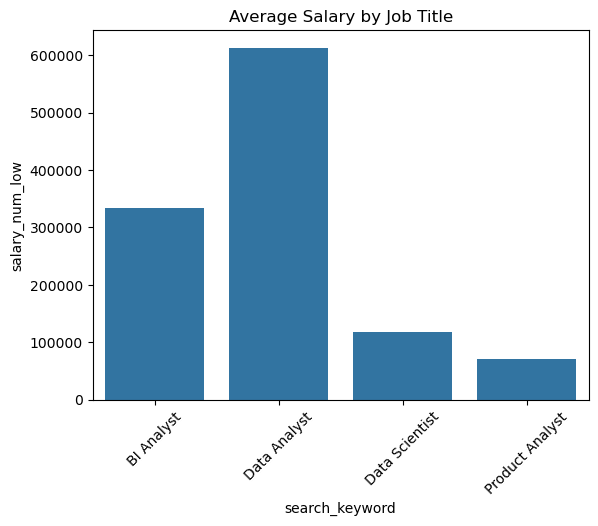

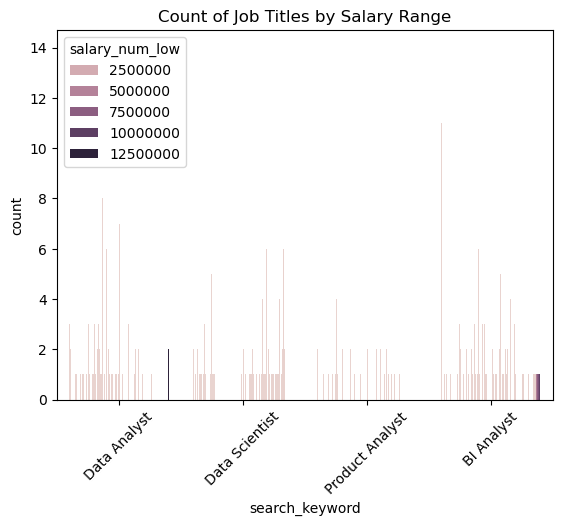

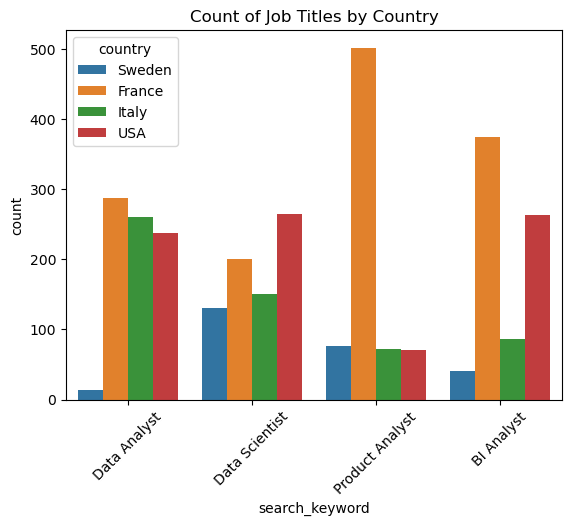

In [49]:
# Please note: salaries are not in the same currency so comparisons cant really be made 
# Use salary conversion 

sns.boxplot(data=df_combined, x='search_keyword', y='salary_num_low')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

mean_salary = df_combined.groupby('search_keyword')['salary_num_low'].mean().reset_index()
sns.barplot(data=mean_salary, x='search_keyword', y='salary_num_low')
plt.xticks(rotation=45)
plt.title('Average Salary by Job Title')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='salary_num_low')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Salary Range')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

In [50]:

import scipy.stats as stats
salary_ranges = pd.cut(df_combined['salary_num_low'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

Chi-squared: 39.48834036396891, p-value: 8.740764936169583e-05


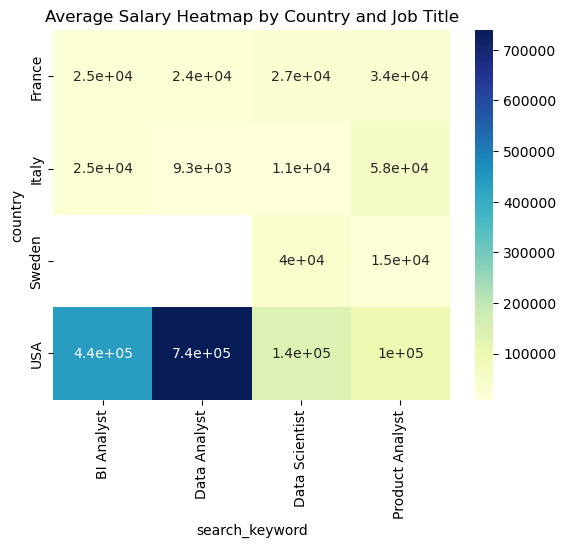

"\ng = sns.FacetGrid(df_clean, col='search_location', col_wrap=3)\ng.map(sns.boxplot, 'search_keyword', 'salary_num_low')\nplt.xticks(rotation=45)\nplt.show()\n"

In [51]:
pivot_table = df_combined.pivot_table(values='salary_num_low', index='country', columns='search_keyword', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Salary Heatmap by Country and Job Title')
plt.show()

'''
g = sns.FacetGrid(df_clean, col='search_location', col_wrap=3)
g.map(sns.boxplot, 'search_keyword', 'salary_num_low')
plt.xticks(rotation=45)
plt.show()
'''

## Conclusions 
TBA.

- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 
- Clean up job titles for different countries?
- Case studies 